In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.robust.norms import HuberT
from skbio.stats.composition import ilr,clr,alr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.DataFrame(pd.read_csv("./city_day.csv"))
df = df.dropna()
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
2123,Amaravati,2017-11-25,81.40,124.50,1.44,20.50,12.08,10.72,0.12,15.24,127.09,0.20,6.50,0.06,184.0,Moderate
2124,Amaravati,2017-11-26,78.32,129.06,1.26,26.00,14.85,10.28,0.14,26.96,117.44,0.22,7.95,0.08,197.0,Moderate
2125,Amaravati,2017-11-27,88.76,135.32,6.60,30.85,21.77,12.91,0.11,33.59,111.81,0.29,7.63,0.12,198.0,Moderate
2126,Amaravati,2017-11-28,64.18,104.09,2.56,28.07,17.01,11.42,0.09,19.00,138.18,0.17,5.02,0.07,188.0,Moderate
2127,Amaravati,2017-11-29,72.47,114.84,5.23,23.20,16.59,12.25,0.16,10.55,109.74,0.21,4.71,0.08,173.0,Moderate


In [3]:
df.describe()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI
count,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000,6236.000000
mean,61.327365,123.418321,17.015191,31.708190,32.448956,20.737070,0.984344,11.514426,36.127691,3.700361,10.323696,2.557439,140.510103
std,53.709682,85.791491,20.037836,18.784041,27.388129,16.088215,1.356161,7.166113,19.553695,5.062159,12.287223,4.535060,92.738826
min,2.000000,7.800000,0.250000,0.170000,0.170000,0.120000,0.000000,0.710000,1.550000,0.000000,0.000000,0.000000,23.000000
25%,27.927500,66.970000,5.080000,15.977500,14.547500,10.390000,0.490000,6.557500,22.357500,0.910000,2.210000,0.300000,78.000000
50%,47.490000,103.010000,10.060000,28.900000,24.285000,14.690000,0.730000,9.875000,32.540000,2.435000,6.310000,1.250000,112.000000
75%,73.442500,150.770000,19.392500,43.632500,39.622500,28.545000,1.060000,14.430000,45.512500,4.620000,13.040000,3.030000,166.000000
max,639.190000,796.880000,159.220000,140.170000,224.090000,166.700000,16.230000,70.390000,162.330000,64.440000,103.000000,125.180000,677.000000


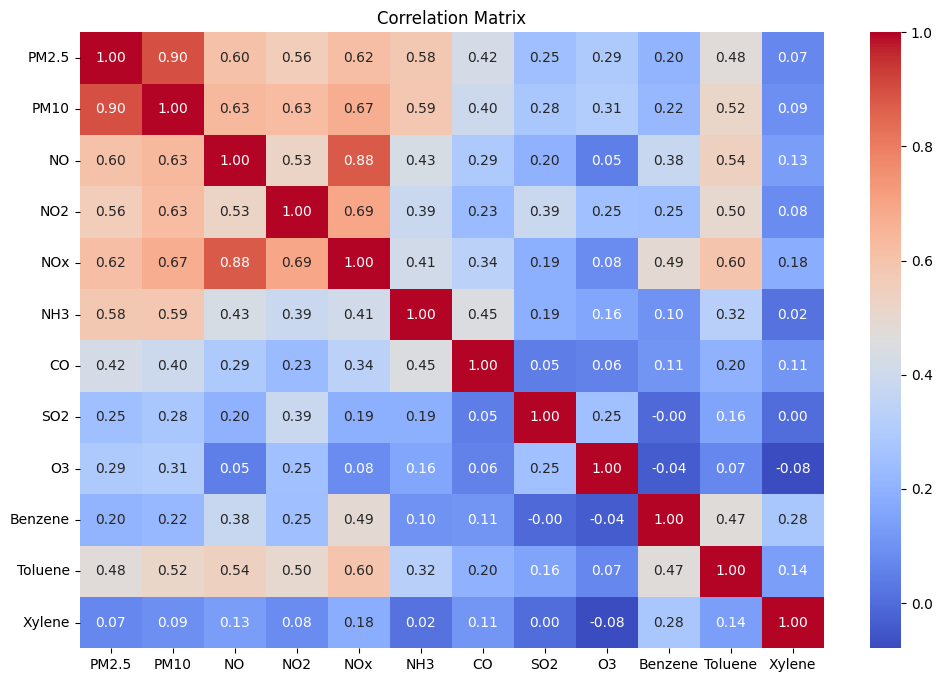

In [4]:
# Biểu đồ heatmap cho ma trận tương quan
plt.figure(figsize=(12, 8))
corr_matrix = df[['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [5]:

compositional_cols = ['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']

total_household_income = df['AQI']

# Tách dữ liệu thành phần
compositional_data = df[compositional_cols]
compositional_data = compositional_data.div(compositional_data.sum(axis=1), axis=0)
compositional_data.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
2123,0.203576,0.311367,0.003601,0.051269,0.030211,0.026810,0.000300,0.038114,0.317844,0.000500,0.016256,0.000150
2124,0.189839,0.312827,0.003054,0.063021,0.035995,0.024918,0.000339,0.065348,0.284662,0.000533,0.019270,0.000194
2125,0.197350,0.300872,0.014674,0.068592,0.048404,0.028704,0.000245,0.074684,0.248599,0.000645,0.016965,0.000267
2126,0.164623,0.266993,0.006566,0.072000,0.043631,0.029293,0.000231,0.048735,0.354435,0.000436,0.012876,0.000180
2127,0.195849,0.310353,0.014134,0.062698,0.044834,0.033105,0.000432,0.028511,0.296571,0.000568,0.012729,0.000216


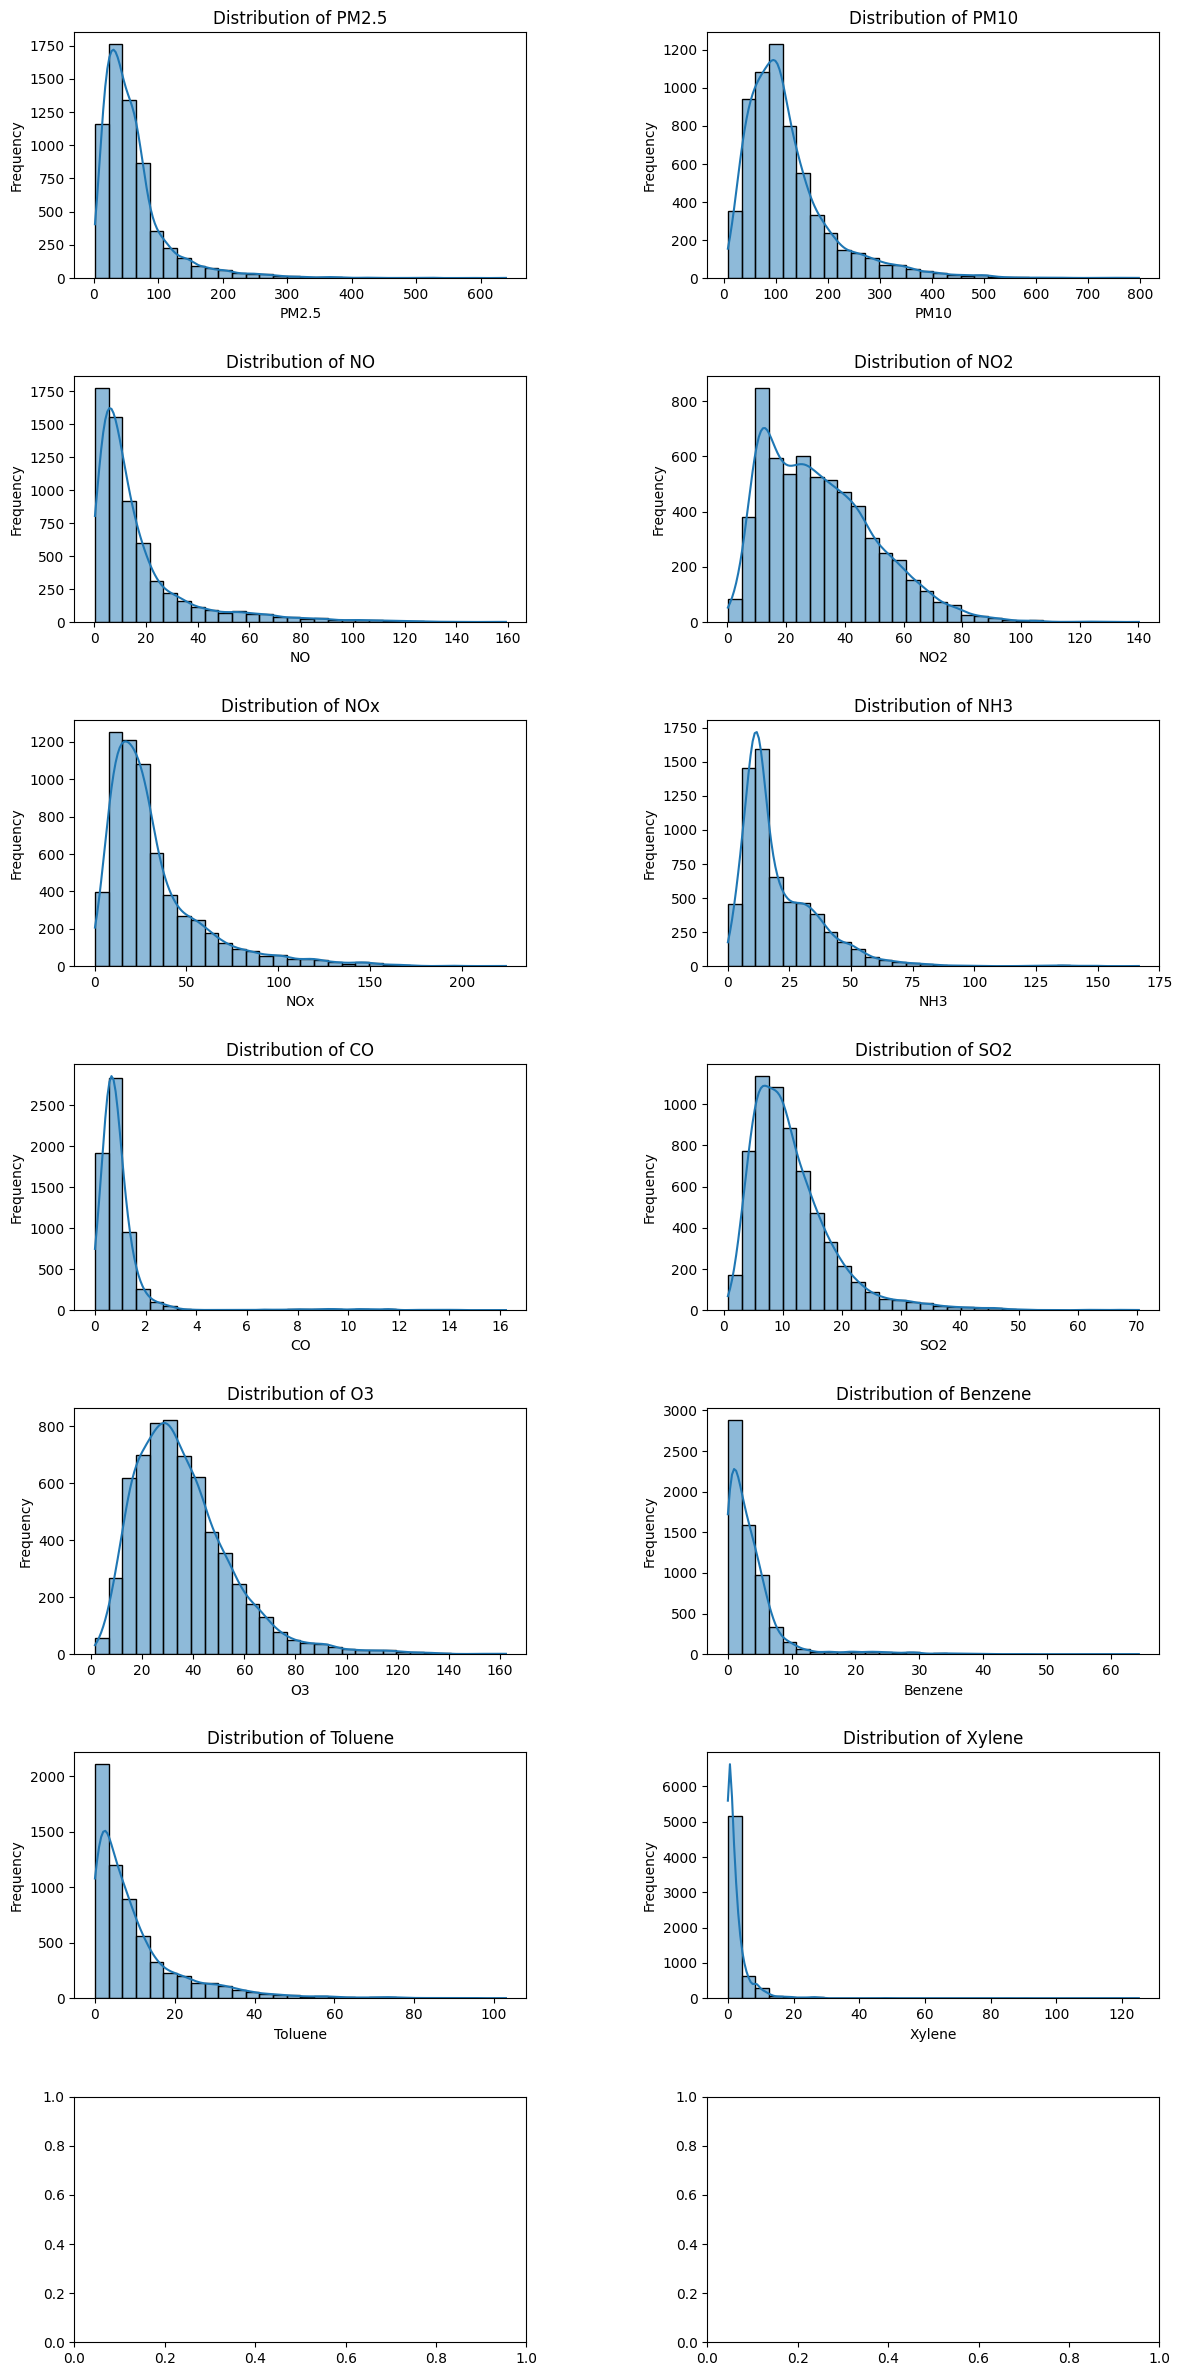

In [6]:
# Histogram và KDE của các biến chính
fig, axes = plt.subplots(nrows=len(compositional_cols)//2 + 1, ncols=2, figsize=(14, 30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, col in enumerate(compositional_cols):
    ax = axes[i // 2, i % 2]
    sns.histplot(df[col].dropna(), kde=True, bins=30, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
plt.show()

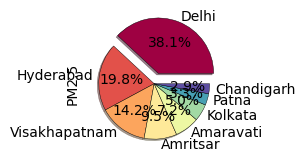

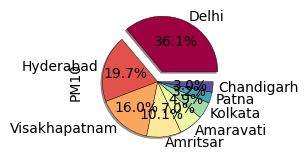

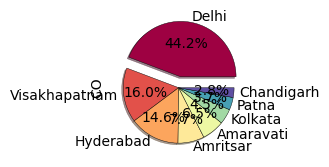

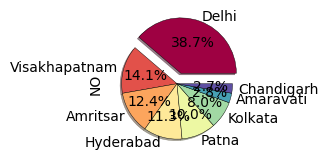

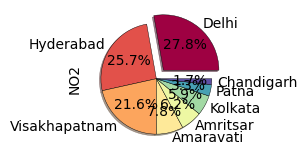

In [7]:
cols=['PM2.5','PM10','CO','NO','NO2']

cmap=plt.get_cmap('Spectral')
color=[cmap(i) for i in np.linspace(0,1,8)]
explode=[0.2,0,0,0,0,0,0,0]

for col in cols:
    plt.figure(figsize=(2.8,1.8))
    
    '''grouping above columns by cities and 
    taking 8 cities which have the highest sum'''
    
    x=df.groupby('City')[col].sum().sort_values(ascending=False)
    x.reset_index('City')
    x[:8].plot.pie(shadow=True,autopct='%1.1f%%',
                   colors=color,explode=explode,
                   wedgeprops={'edgecolor':'black','linewidth':0.3}
                   )

In [8]:
# Thay thế các giá trị bằng 0 bằng một epsilon nhỏ
epsilon = 1e-9
compositional_data = compositional_data.replace(0, epsilon)

# Chuyển đổi dữ liệu thành phần bằng centered log-ratio (CLR)
clr_compositional_data = clr(compositional_data)

# Chuyển dữ liệu CLR về dạng DataFrame để tiện sử dụng
clr_compositional_data = pd.DataFrame(clr_compositional_data)
clr_compositional_data.columns = compositional_cols

clr_compositional_data.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene
0,2.701882,3.126812,-1.332850,1.322932,0.794058,0.674618,-3.817757,1.026430,3.147402,-3.306931,0.174309,-4.510904
1,2.538639,3.038113,-1.591053,1.435932,0.875835,0.508036,-3.788277,1.472190,2.943763,-3.336292,0.251007,-4.347893
2,2.398767,2.820474,-0.200099,1.341968,0.993364,0.470834,-4.294444,1.427060,2.629632,-3.325043,-0.055081,-4.207432
3,2.411851,2.895415,-0.809833,1.584861,1.083961,0.685526,-4.157786,1.194598,3.178717,-3.521797,-0.136411,-4.409101
4,2.464458,2.924826,-0.164303,1.325438,0.990086,0.686812,-3.651296,0.537412,2.879400,-3.379362,-0.269026,-4.344443


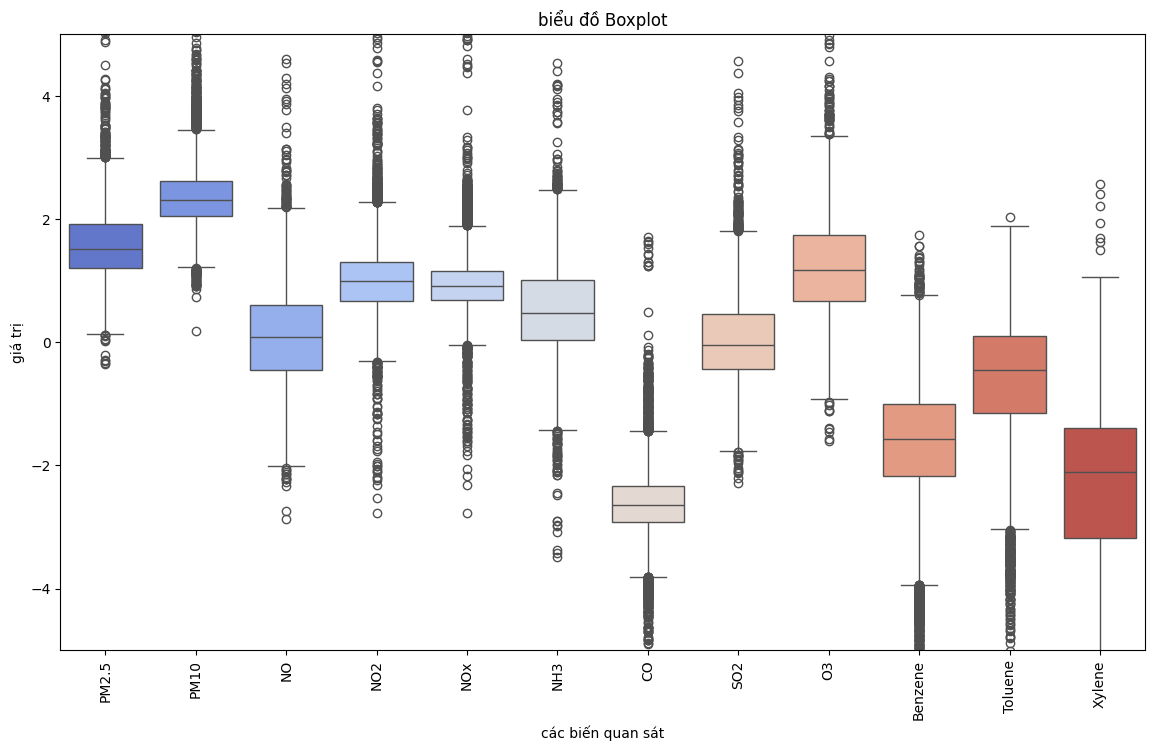

In [9]:
# Vẽ boxplot để xem phân phối của các biến
plt.figure(figsize=(14, 8))
X_scaled_melt = clr_compositional_data.melt(var_name='các biến quan sát', value_name='giá trị')
sns.boxplot(x='các biến quan sát', y='giá trị', data=X_scaled_melt, palette='coolwarm', hue='các biến quan sát', dodge=False, legend=False)
plt.title('biểu đồ Boxplot')
plt.xticks(rotation=90)
plt.ylim(-5, 5)
plt.show()

In [10]:

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra với biến phụ thuộc là dữ liệu đa hợp đã được phân tích
X_train, X_test, y_train, y_test = train_test_split(clr_compositional_data, total_household_income, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# In kết quả mô hình
print(rlm_results.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:                    AQI   No. Observations:                 4988
Model:                            RLM   Df Residuals:                     4976
Method:                          IRLS   Df Model:                           11
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 28 Jun 2024                                         
Time:                        15:08:32                                         
No. Iterations:                    29                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        134.4093      0.790    170.063      0.0

In [11]:
# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 60.91412060963466


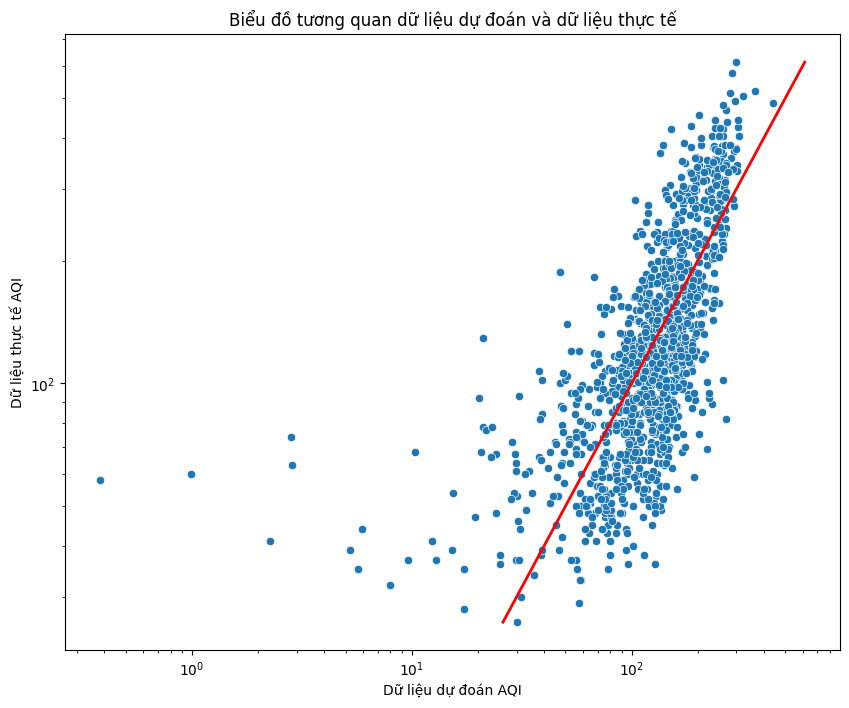

In [12]:
# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dữ liệu dự đoán AQI')
plt.ylabel('Dữ liệu thực tế AQI')
plt.title('Biểu đồ tương quan dữ liệu dự đoán và dữ liệu thực tế')
plt.show()

RMSE: 60.91412060963466


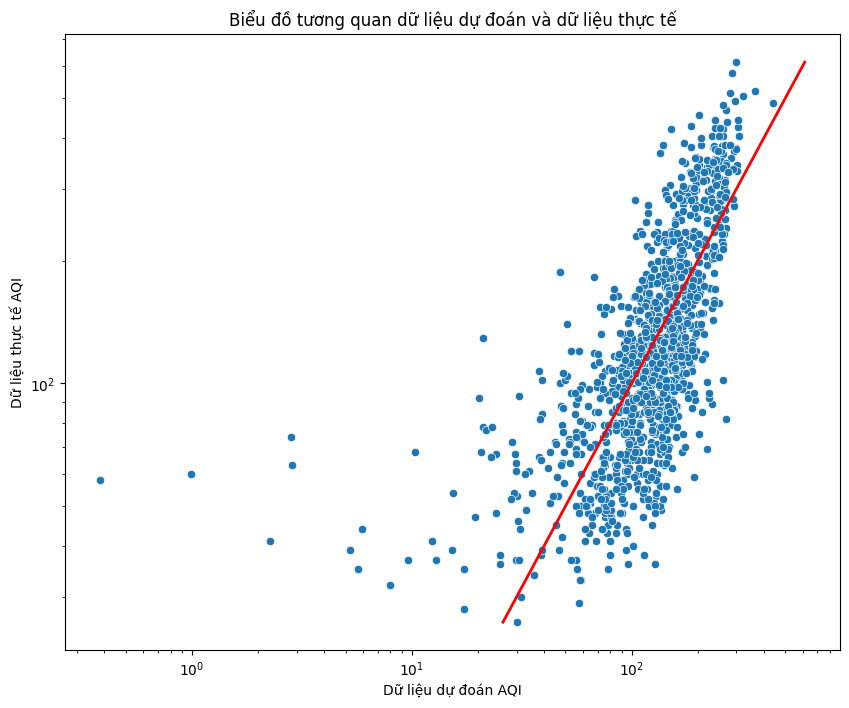

In [13]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra với biến phụ thuộc là dữ liệu đa hợp đã được phân tích
X_train, X_test, y_train, y_test = train_test_split(clr_compositional_data, total_household_income, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Thêm cột hằng số vào X_train và X_test cho mô hình hồi quy
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Tạo mô hình hồi quy mạnh mẽ (RLM) với chuẩn Huber
rlm_model = sm.RLM(y_train, X_train_scaled, M=HuberT())
rlm_results = rlm_model.fit()

# Dự đoán trên tập kiểm tra
y_pred = rlm_results.predict(X_test_scaled)

# Tính toán lỗi và RMSE
error = y_pred - y_test
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Vẽ biểu đồ dự đoán so với giá trị thực tế
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Dữ liệu dự đoán AQI')
plt.ylabel('Dữ liệu thực tế AQI')
plt.title('Biểu đồ tương quan dữ liệu dự đoán và dữ liệu thực tế')
plt.show()